# Joint RV & transit fits, TOI 1273

In [1]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares


import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import os
import warnings
os.environ["MKL_THREADING_LAYER"] = "GNU"
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

## Datasets and initializations
Lets start with the transits from TESS

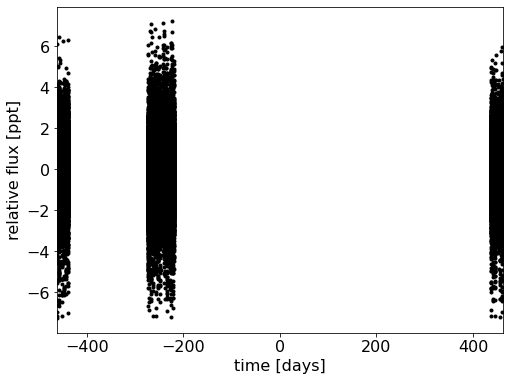

In [2]:
lc_file = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux


with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.plot(x_, y_, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x_.min(), x_.max())
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

In [3]:
period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x_, y_, yerr)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)

bls period: 4.631316790471438
bls t0: -461.34256457198444
bls depth: 2.062291019979162
ref_time: 2173.6753273248096
epoch: 1712.3327627528251


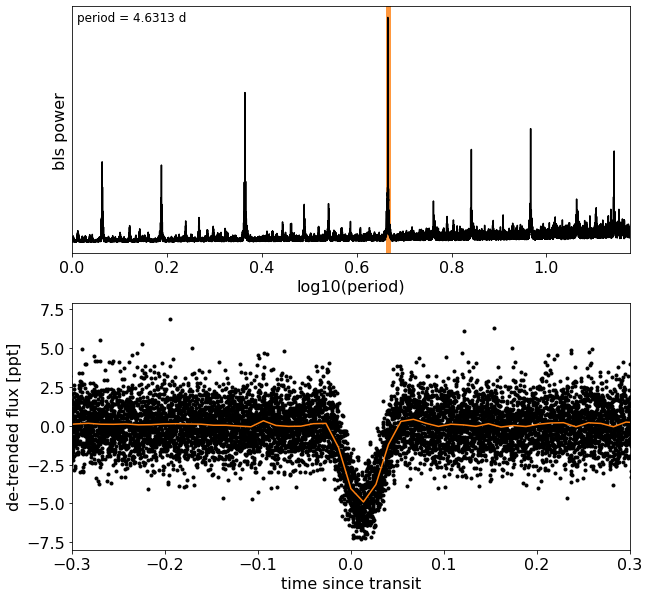

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax.plot(x_fold_, y_, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 62)
denom, _ = np.histogram(x_fold_, bins)
num, _ = np.histogram(x_fold_, bins, weights=y_)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")
#plt.savefig('bls_1199.png',dpi=300,bbox_inches='tight')

(-0.12, 0.12)

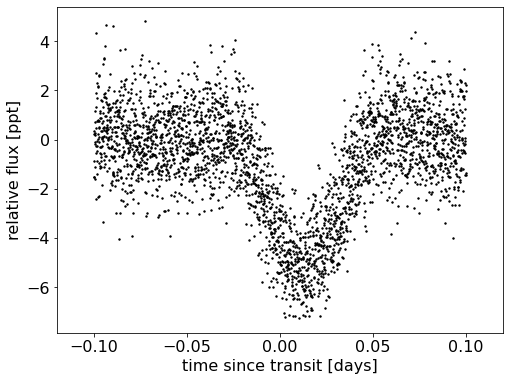

In [5]:
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
plt.xlim(-0.12,0.12)

Now the SOPHIE RVs.

46


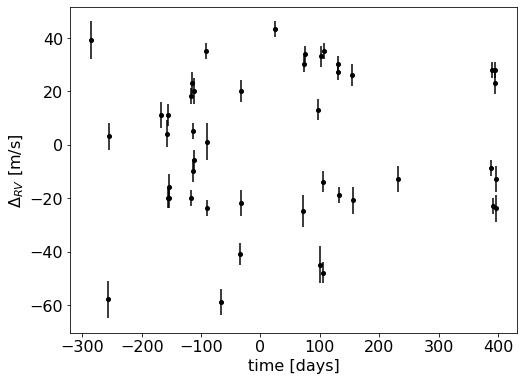

In [6]:
data = pd.read_table('1273_preliminary_rv_sophie.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err'}, inplace=True)

x_rv = np.array(data.bjd-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

Estimate the planet minimum mass and the semiamplitude.

In [38]:
import exoplanet as xo
import astropy.units as u

# Stellar parameters from Sousa
M_star = 0.98, 0.02
R_star = 1.07, 0.03

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print('K=', K, "m/s")

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print('minimum mass=', msini)

K= [31.39023586] m/s
minimum mass= [80.72751866] earthMass


## Joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.

In [39]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 150)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:
        
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=5.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value[0]), sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        b = pm.Uniform("b", lower=0, upper=1.5)
        # # Fit in terms of transit depth (assuming b<1)
        # log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        # ror = pm.Deterministic(
        #     "ror",
        #     star.get_ror_from_approx_transit_depth(
        #         1e-3 * tt.exp(log_depth), b
        #     ),
        # )

        # # Or sample ror directly instead of depth, because b is really close to 1
        log_ror = pm.Normal("log_ror", mu=0.5*np.log(bls_depth * 1e-3), sd=1.0)
        ror = pm.Deterministic("ror", tt.exp(log_ror))

        r_pl = pm.Deterministic("r_pl", ror * r_star)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        #xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit jitter
        logs = pm.Uniform("logs", lower=0, upper=1,testval=np.log(np.std(y)))

        # Wide log-normal prior for semi-amplitude
        #logK = pm.Normal("logK", mu=np.log(K.item()), sd=2.0)

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)* 1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # The likelihood for the light curve
        pm.Normal("transit_obs", mu=light_curve, sd=tt.exp(logs), observed=y[mask])

        # Compute a reference time that will be used to normalize the trends model
        x_ref = 0.5 * (x_rv.min() + x_rv.max())
        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            #vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred",
            1e3 * star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp)[..., 0],)

        # Fit for the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start, vars=[trend])
        map_soln = pmx.optimize(start=map_soln, vars=[logs])
        map_soln = pmx.optimize(start=map_soln, vars=[t0, log_period])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = pmx.optimize(start=map_soln, vars=[log_ror]) # or log_depth
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_sigma_rv])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(start=map_soln)

        extras = pmx.eval_in_model(light_curves, map_soln)

    return model, map_soln, extras

model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -6841.084482909642 -> -6835.449408607905
optimizing logp for variables: [logs]


message: Optimization terminated successfully.
logp: -6835.449408607905 -> -6772.268348354787
optimizing logp for variables: [log_period, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -6772.268348354785 -> -6757.345938551035
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -6757.345938551036 -> -6670.59031054261
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -6670.59031054261 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [log_m_pl]


message: Optimization terminated successfully.
logp: -6670.590310542611 -> -6644.498455181223
optimizing logp for variables: [log_ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -6644.498455181223 -> -6514.170091964801
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -6514.170091964801 -> -6472.957990426038
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -6472.957990426038 -> -6440.1104540545275
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -6440.1104540545275 -> -6440.107783764228
optimizing logp for variables: [logs, trend, log_sigma_rv, ecs, log_ror, b, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -6440.107783764228 -> -5219.933898645689


Now let's plot the map radial velocity model.

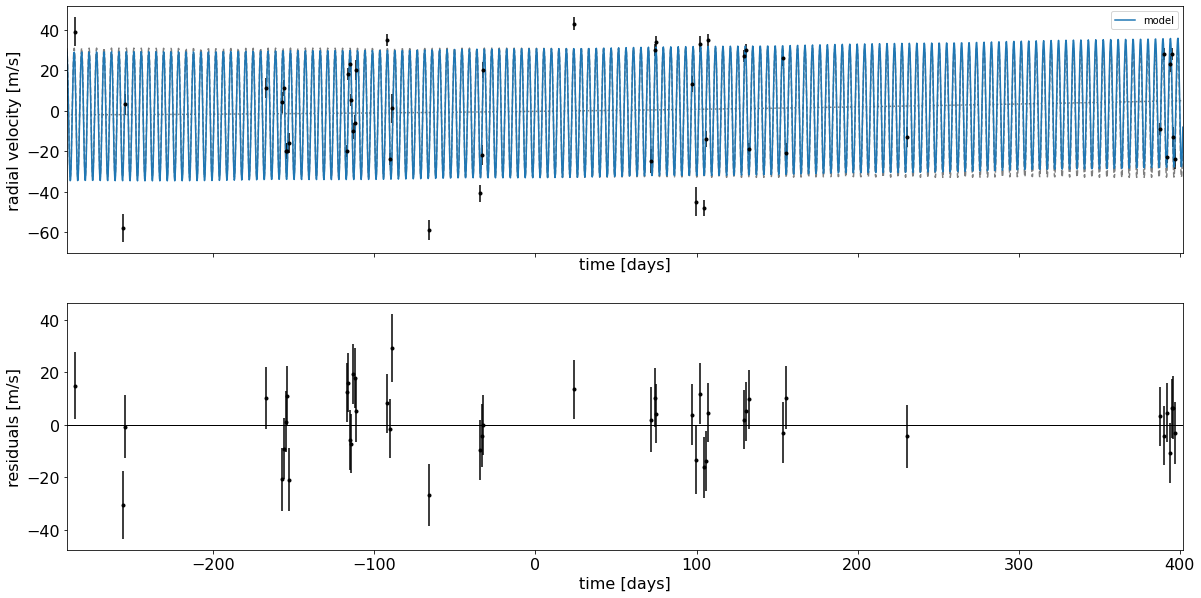

In [40]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln0)

Now let's also plot the transit model.

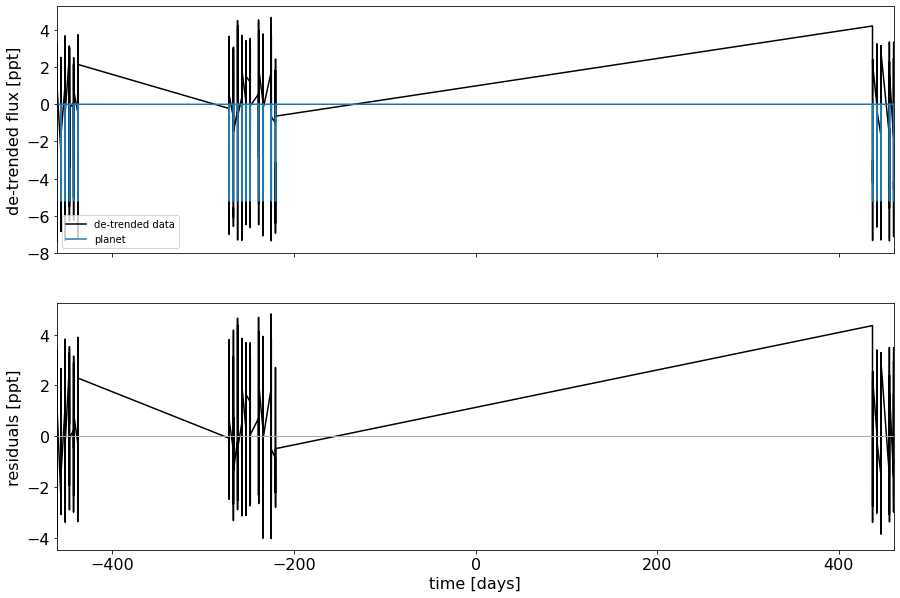

In [41]:
# We plot the initial light curve model:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask] - soln['mean'], "k", label="de-trended data")
    mod = extras
    ax.plot(x[mask], mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[1]
    mod = np.sum(extras, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    #plt.xlim(-93,-92)
    return fig


_ = plot_light_curve(map_soln0, extras0)

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the transit model and remove anything that is more than a 7-sigma outlier.

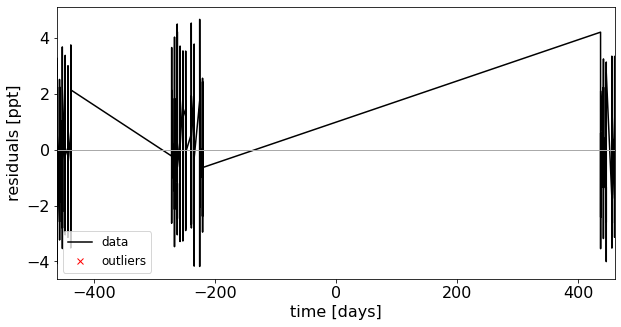

In [42]:
# We can do some sigma clipping to remove significant outliers.
mod = (map_soln0["mean"] + np.sum(extras0, axis=-1))

resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())
#plt.xlim(-450,-435)

Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]


message: Desired error not necessarily achieved due to precision loss.
logp: -5219.933898645688 -> -5219.933898645687
optimizing logp for variables: [logs]


message: Optimization terminated successfully.
logp: -5219.933898645687 -> -5219.933898645687
optimizing logp for variables: [log_period, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -5219.933898645688 -> -5219.933898645653
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -5219.933898645654 -> -5219.933898645654
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -5219.933898645654 -> -5219.933898645654
optimizing logp for variables: [log_m_pl]


message: Optimization terminated successfully.
logp: -5219.933898645653 -> -5219.933898645653
optimizing logp for variables: [log_ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -5219.933898645654 -> -5219.933898645654
optimizing logp for variables: [b]


message: Desired error not necessarily achieved due to precision loss.
logp: -5219.933898645654 -> -5219.933898645654
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -5219.933898645654 -> -5219.933898645654
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -5219.933898645654 -> -5219.933898645644
optimizing logp for variables: [logs, trend, log_sigma_rv, ecs, log_ror, b, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -5219.933898645644 -> -5219.933898645644


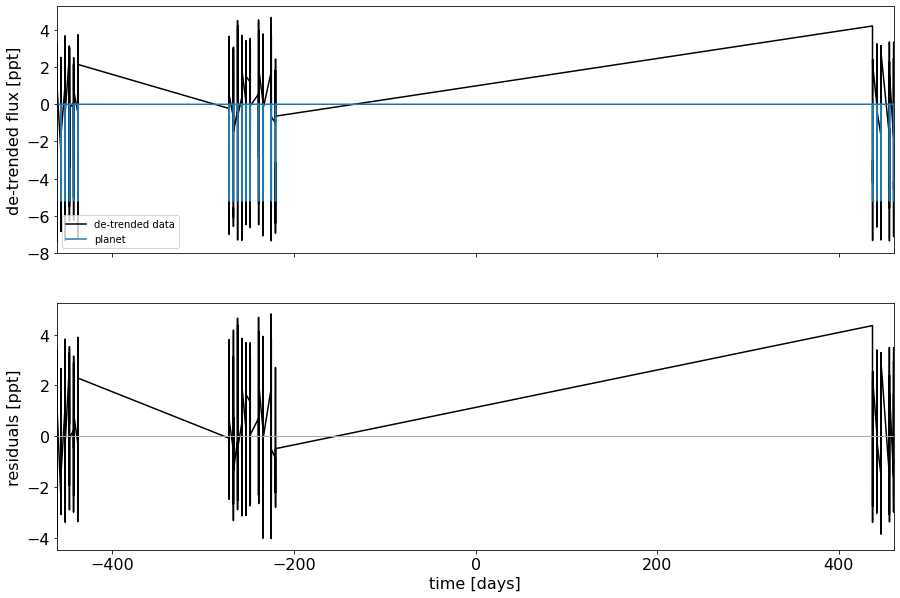

In [43]:
# looks like we don't have any outliers 
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

Great! Now we're ready to sample.

## Sampling

In [44]:
import multiprocessing

with model:
    trace = pm.sample(
        tune=2500, #1500,
        draws=2000, #1000,
        start=map_soln,
        cores=4,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000, 261136679, 261136680],
        #mp_ctx=multiprocessing.get_context("fork"),
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/juan/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logs, trend, log_sigma_rv, ecs, log_ror, b, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 8292 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [53]:
import arviz as az

az.summary(
    trace,
    var_names=[
        'logs',
        'trend',
        'log_sigma_rv',
        'ecs',
        'log_ror', # log_ror or log_depth
        'b',
        'log_period',
        'log_m_pl',
        't0',
        'r_star',
        'm_star',
        'u_star',
        'mean',
        'period',
        "r_pl",
        "m_pl",
        "ecc",
        "omega",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logs,0.286,0.013,0.264,0.312,0.000,0.000,7861.0,6330.0,1.0
trend[0],0.000,0.000,-0.000,0.000,0.000,0.000,6276.0,4420.0,1.0
trend[1],0.010,0.010,-0.008,0.028,0.000,0.000,7459.0,5275.0,1.0
trend[2],0.301,0.944,-1.353,2.189,0.011,0.012,6842.0,3814.0,1.0
log_sigma_rv,2.448,0.131,2.205,2.695,0.002,0.001,5262.0,5492.0,1.0
ecs[0],-0.066,0.123,-0.284,0.155,0.002,0.001,5774.0,6531.0,1.0
ecs[1],0.020,0.147,-0.245,0.282,0.003,0.002,3379.0,4249.0,1.0
log_ror,-2.070,0.247,-2.442,-1.549,0.009,0.006,952.0,392.0,1.0
b,0.995,0.045,0.925,1.096,0.002,0.001,1020.0,413.0,1.0
log_period,1.533,0.000,1.533,1.533,0.000,0.000,7891.0,5717.0,1.0


In [46]:
#tune 3500, draws 2000, 2 chains, 2 cores
#           mean	sd	hdi_3%	hdi_97%	mcse_mean	mcse_sd	ess_bulk	ess_tail	r_hat
# period	4.631	0.000	4.631	4.631	0.000	0.000	4418.0	3025.0	1.0
# r_pl	    0.117	0.014	0.091	0.143	0.000	0.000	871.0	1412.0	1.0
# m_pl	    81.954	6.252	70.147	93.846	0.102	0.072	3744.0	2496.0	1.0
# ecc	    0.045	0.032	0.000	0.100	0.001	0.000	2150.0	3181.0	1.0
# omega	    0.729	2.001	-2.860	3.135	0.050	0.035	2106.0	1153.0	1.0
# b	        0.966	0.020	0.931	1.000	0.001	0.000	648.0	354.0	1.0
# u_star[0]	0.684	0.429	0.001	1.403	0.008	0.006	2374.0	2223.0	1.0
# u_star[1]	0.076	0.421	-0.723	0.762	0.009	0.007	2162.0	2154.0	1.0
# trend[0]	0.000	0.000	-0.000	0.000	0.000	0.000	2496.0	1135.0	1.0
# trend[1]	0.009	0.010	-0.007	0.028	0.000	0.000	3188.0	2824.0	1.0
# trend[2]	0.311	0.930	-1.413	2.068	0.017	0.014	2988.0	2951.0	1.0

In [54]:
radio = trace.posterior["r_pl"].mean().item()*9.73116
radio_err = trace.posterior["r_pl"].std().item()*9.73116
masa = trace.posterior["m_pl"].mean().item()*0.00314558
masa_err = trace.posterior["m_pl"].std().item()*0.00314558
periodo = trace.posterior['period'].mean().item()
periodo_sigma = trace.posterior['period'].std().item()
t_0 = trace.posterior['t0'].mean().item()+ref_time
t_0_sigma = trace.posterior['t0'].std().item()
print("Radio = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio, r_err=radio_err))
print("Masa = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa, m_err=masa_err))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_0, e_s=t_0_sigma))

Radio = 1.363 ± 0.379 Rj
Masa = 0.256 ± 0.020 Mj
Periodo = 4.631301 ± 0.000003
Epoca = 1712.34651 ± 0.0004


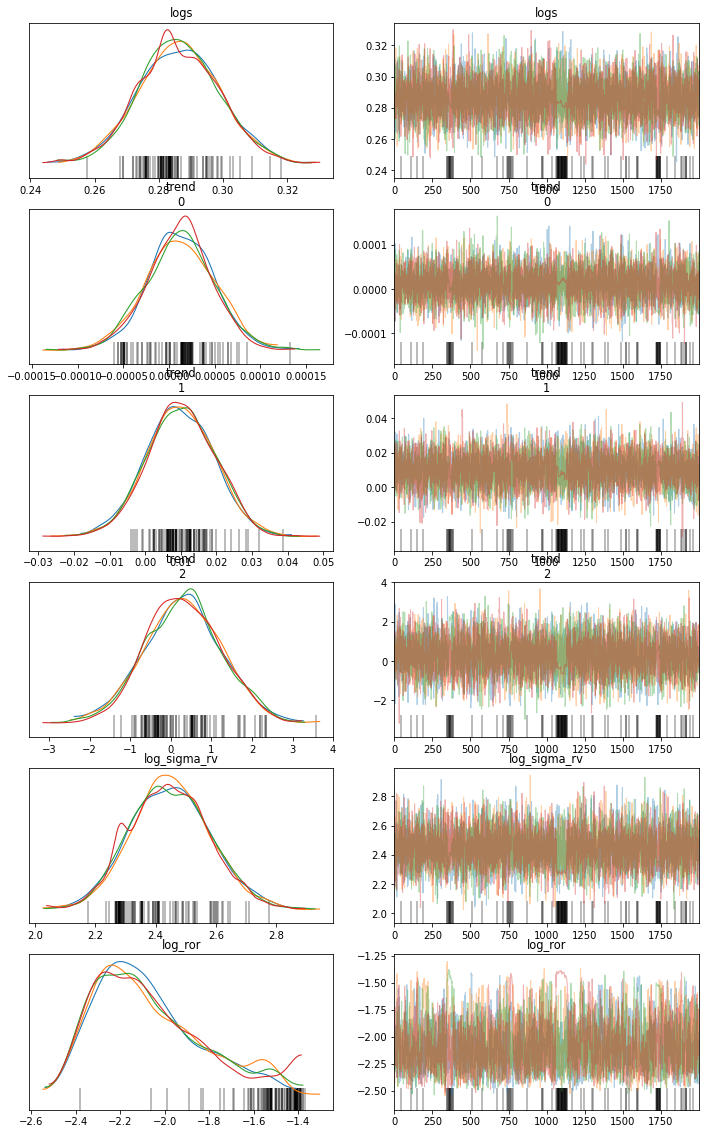

In [48]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

_ = az.plot_trace(trace, var_names=['logs', 'trend','log_sigma_rv', 'log_ror'] # log_ror instead of log_depth
                                    , compact=False, figsize=(12,20)) # SAMPLED 1
# _ = az.plot_trace(trace, var_names=['log_period', 'log_m_pl', 't0', 'r_star', 'm_star']
#                                    , compact=False, figsize=(12,20)) # SAMPLED 2
# _ = az.plot_trace(trace, var_names=['ecs', 'b', 'u_star', 'mean']
#                                    , compact=False, figsize=(12,25)) # SAMPLED 3
# plt.savefig('trace_joint_1273_reparam_3.png',dpi=200,bbox_inches='tight')

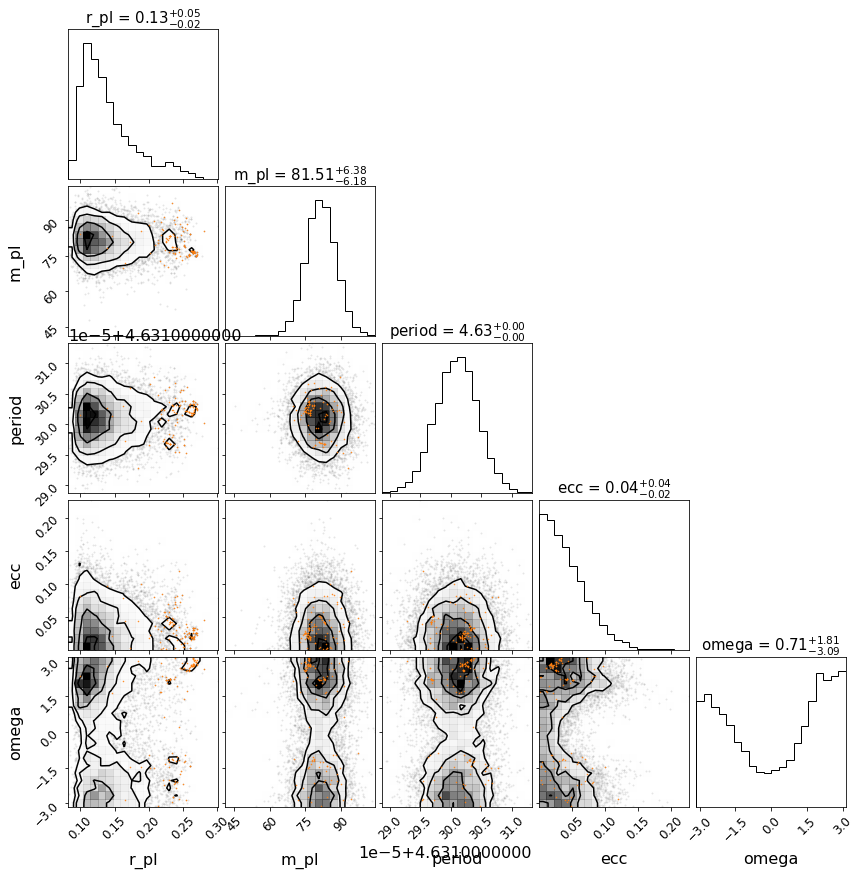

In [56]:
import corner

figure = corner.corner(trace, var_names=['ecs', 'log_ror', 'b', 'log_m_pl', 'u_star'],  #log_ror or log_depth
                        show_titles=True, title_kwargs={'fontsize':15}, divergences=True) # SAMPLED [logs, trend, log_sigma_rv, ecs, log_depth, b, 
                                                                                            # log_period, log_m_pl, t0, r_star, m_star, u_star, mean]
# figure = corner.corner(trace, var_names=['r_pl', 'm_pl', 'period', 'ecc', 'omega'], 
#                         show_titles=True, title_kwargs={'fontsize':15}, divergences=True) # NOT SAMPLED
figure.subplots_adjust(right=1, top=1)
for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=12)
# plt.savefig('trace_corner_1273_reparam_notsampled.png',dpi=200,bbox_inches='tight')

## Phase plots

(-8.0, 5.2)

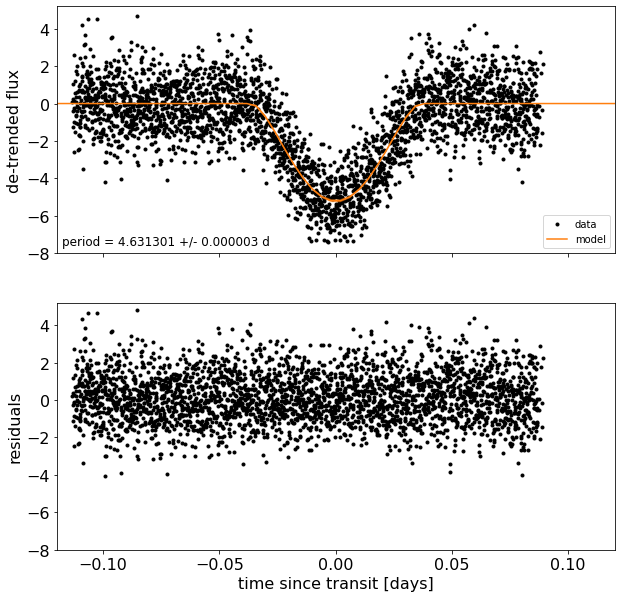

In [57]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p_ = np.median(flat_samps["period"])
t0_ = np.median(flat_samps["t0"])

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# Plot the folded data
ax = axes[0]
x_fold2 = (x[mask] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax.plot(x_fold2, y[mask] - map_soln['mean'], ".k", label="data", zorder=-1000)


# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
ax.plot(phase_lc, pred[1], color="C1", label="model")
art = ax.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.6f} +/- {1:.6f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values))

ax.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

ax.legend(fontsize=10, loc=4)
ax.set_ylabel("de-trended flux")
plt.xlim(-0.12, 0.12)
ax.set_ylim(-8,5.2)

ax = axes[1]
_= ax.plot(x_fold2, y[mask] - np.sum(extras, axis=-1), ".k", label="data", zorder=-1000)
ax.set_ylabel('residuals')
ax.set_xlabel("time since transit [days]")
ax.set_ylim(-8,5.2)
#plt.savefig('fit_transit_joint_1273.png',dpi=200,bbox_inches='tight')

Text(0.5, 0, 'time since transit [days]')

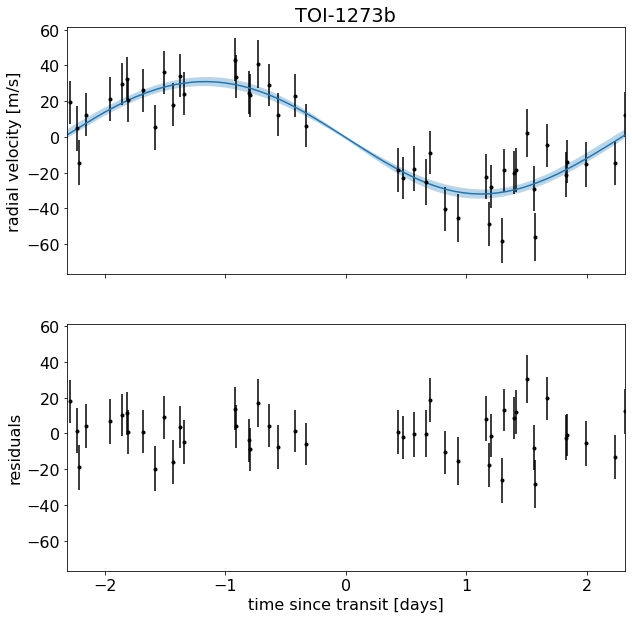

In [58]:
rv_jitter = np.exp(np.median(flat_samps['log_sigma_rv']))
bkg_ = np.median(flat_samps['bkg'].values, axis=-1)
rv_model_ = np.median(flat_samps['rv_model'].values, axis=-1)

# Plot the folded data
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
ax = axes[0]
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax.errorbar(x_fold, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt=".k")

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
ax.plot(t_fold[inds], pred[1], color="C0", label="model")
art = ax.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

#ax.set_legend(fontsize=10)
ax.set_xlim(-0.5 * p_, 0.5 * p_)
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("TOI-1273b")

# Plot the folded residuals
ax = axes[1]
_= ax.errorbar(x_fold, y_rv-rv_model_ - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt=".k", label='residuals')
ax.set_ylabel('residuals')
ax.set_xlabel("time since transit [days]")
#plt.savefig('fit_rv_joint_1273.png',dpi=200,bbox_inches='tight')

We can also compute the posterior constraints on the planet densitiy.

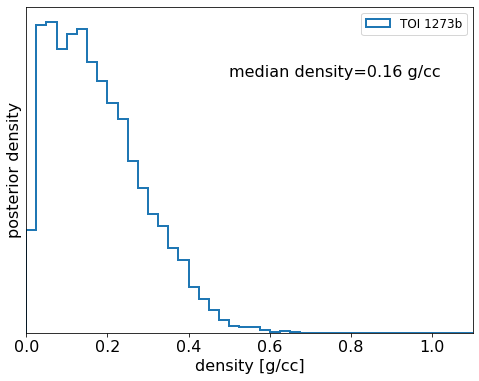

In [60]:
volume = 4 / 3 * np.pi * flat_samps["r_pl"].values ** 3
density = u.Quantity(flat_samps["m_pl"].values / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
plt.hist(
        density,
        bins,
        histtype="step",
        lw=2,
        label='TOI 1273b',
        density=True,)
plt.yticks([])
plt.text(0.5, 3, 'median density={:.2f} g/cc'.format(np.median(density)))
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")
#plt.savefig('density_joint_1273_reparam.png',dpi=200,bbox_inches='tight')